In [1]:
import os
from pathlib import Path
import pickle
from tqdm import tqdm
from datasets import load_dataset

curr_dir = Path(os.getcwd())
data_dir = curr_dir / 'data'
data_pickle_path = data_dir / 'data_set.pkl'
vectordb_dir = curr_dir / 'vectore_storage'
chroma_dir = vectordb_dir / 'chroma'
for dir in [data_dir, vectordb_dir, chroma_dir]:
    if not os.path.exists(dir):
        os.mkdir(dir)

if not os.path.exists(data_pickle_path):
    print(f"Data set hasn't been loaded. Loading from the datasets library and save it as a pickle.")
    data_set = load_dataset("vipulmaheshwari/GTA-Image-Captioning-Dataset")
    with open(data_pickle_path, 'wb') as outfile:
        pickle.dump(data_set, outfile)
else:
    print(f"Data set already exists in the local drive. Loading it.")
    with open(data_pickle_path, 'rb') as infile:
        data_set = pickle.load(infile)

Data set already exists in the local drive. Loading it.


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/clip-ViT-L-14")

In [ ]:
img_embeddings = []
for image in tqdm(data_set['train']['image'][2:5]):
    img_embedding = model.encode(image)
    img_embeddings.append(img_embedding)

In [2]:
# print(data_set)
# len(data_set['train']['image']), len(data_set['train']['text'])

In [3]:
# Source: https://huggingface.co/sentence-transformers/clip-ViT-L-14

from sentence_transformers import SentenceTransformer, util
# from PIL import Image

#Load CLIP model
model = SentenceTransformer("sentence-transformers/clip-ViT-L-14") # SentenceTransformer('clip-ViT-L-14')

#Encode an image:
# img_emb = model.encode(image) # Image.open('two_dogs_in_snow.jpg')

# #Encode text descriptions
# text_emb = model.encode(text) # ['Two dogs in the snow', 'A cat on a table', 'A picture of London at night']

# #Compute cosine similarities 
# cos_scores = util.cos_sim(img_emb, text_emb)
# print(cos_scores)

In [30]:
ids = []
img_embeddings = []
for id, image in tqdm(zip(list(range(2, 5, 1)), data_set['train']['image'][2:5])):
    ids.append("image "+str(id))

    img_embedding = model.encode(image)
    img_embeddings.append(img_embedding.tolist())

3it [00:11,  3.76s/it]


# try FAISS. Chroma, Pinecone (check the GAFS project)

In [33]:
import chromadb

# Initialize Chroma DB client
# client = chromadb.Client()
client = chromadb.PersistentClient(path=chroma_dir.__str__())

# collection = client.create_collection(name="my_collection", embedding_function=emb_fn)
# collection = client.get_collection(name="my_collection", embedding_function=emb_fn)
# client.delete_collection(name="image_vectors") # Delete a collection and all associated embeddings, documents, and metadata. ⚠️ This is destructive and not reversible
collection = client.get_or_create_collection(name='image_vectors')

# for i, img_embedding in enumerate(img_embeddings):
#     collection.add({
#         'id': i,
#         'vector': img_embedding.tolist()
#     })
collection.add(
    # documents=["string", "list"],
    ids=ids, # ["image "+str(i) for i in range(len(img_embeddings))]
    embeddings=img_embeddings # [img_embedding.tolist() for img_embedding in img_embeddings]
)

In [34]:
query = "red car"
results = collection.query(
    # query_texts=["texts"],
    query_embeddings=model.encode([query]),
    n_results=2
    )
results

{'ids': [['image 3', 'image 4']],
 'distances': [[440.70768169459603, 453.84339480687305]],
 'metadatas': [[None, None]],
 'embeddings': None,
 'documents': [[None, None]],
 'uris': None,
 'data': None}

In [38]:
img_id = int(results['ids'][0][0].split('image ')[-1])
img_id

3

Description: there is a picture of a street with a red car driving down it


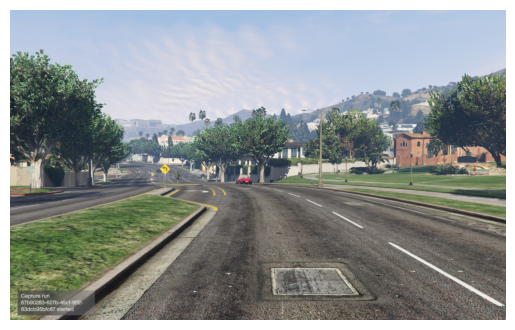

In [39]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
plt.axis("off")

image = data_set['train']['image'][img_id]
text = data_set['train']['text'][img_id]

plt.imshow(image)
print(f"Description: {text}")

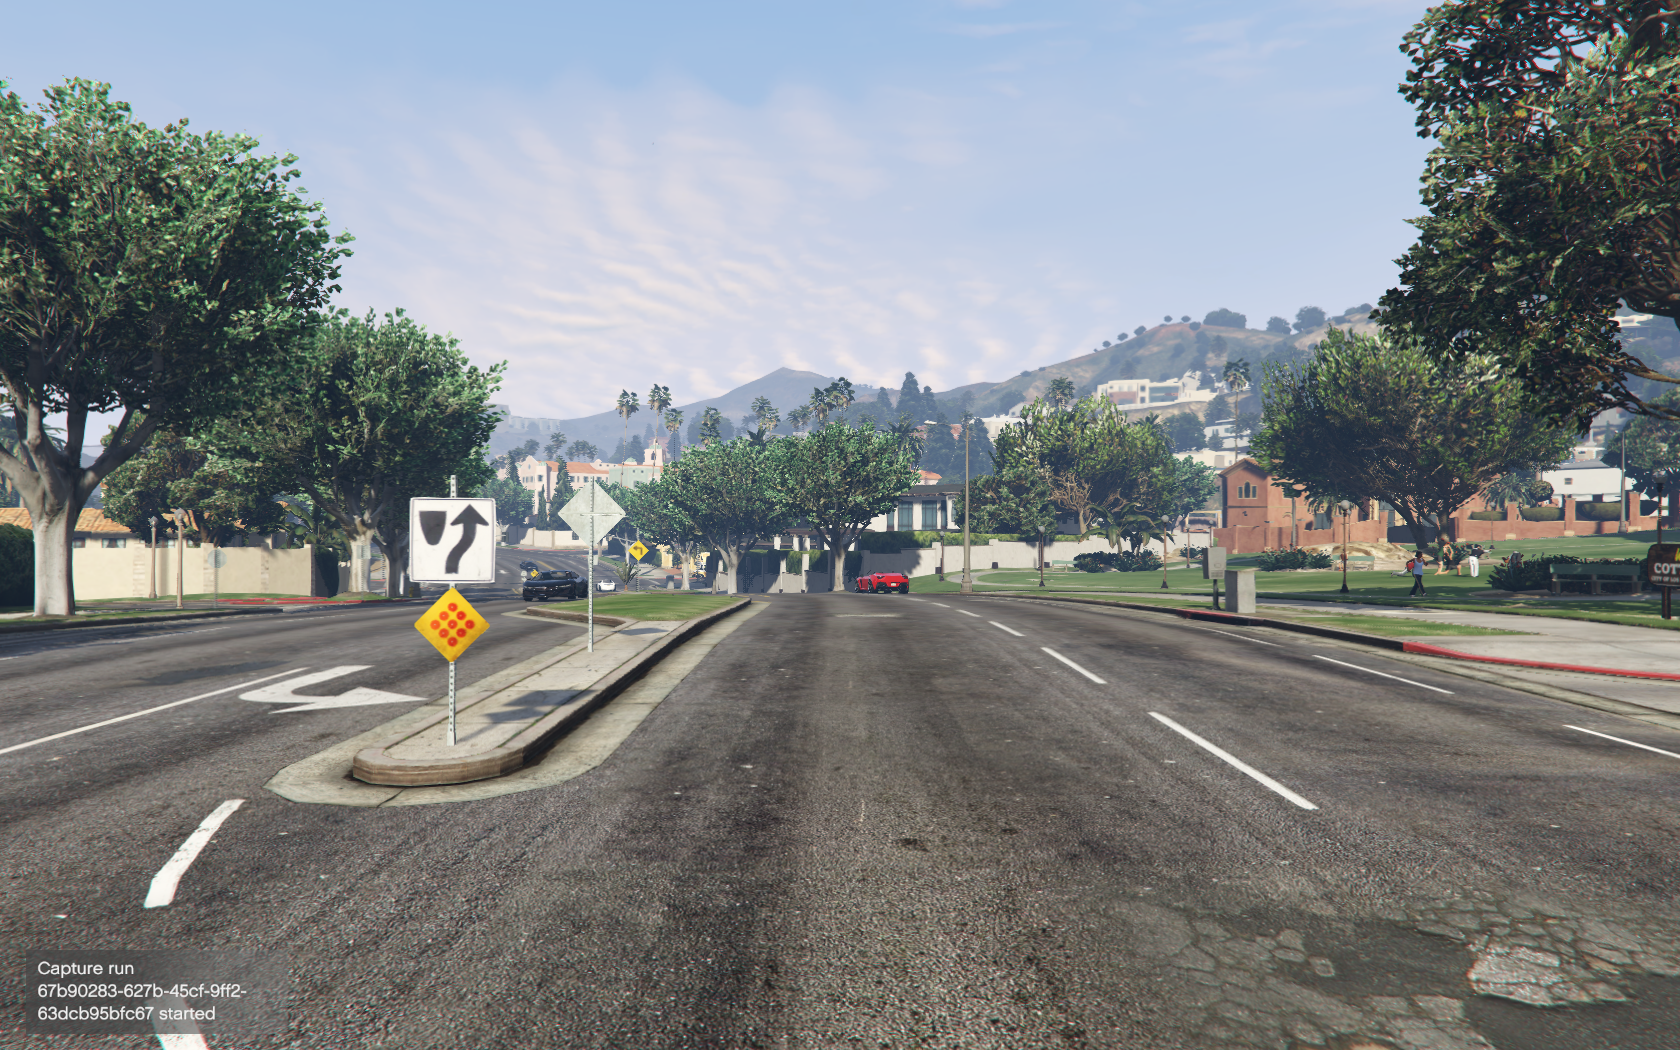

In [9]:
# data_set['train']['image'][img_id]

In [10]:
# import chromadb
# # setup Chroma in-memory, for easy prototyping. Can add persistence easily!
# client = chromadb.Client()

# # Create collection. get_collection, get_or_create_collection, delete_collection also available!
# collection = client.create_collection("all-my-documents")

# # Add docs to the collection. Can also update and delete. Row-based API coming soon!
# collection.add(
#     documents=["This is document1", "This is document2"], # we handle tokenization, embedding, and indexing automatically. You can skip that and add your own embeddings as well
#     metadatas=[{"source": "notion"}, {"source": "google-docs"}], # filter on these!
#     ids=["doc1", "doc2"], # unique for each doc
# )

# # Query/search 2 most similar results. You can also .get by id
# results = collection.query(
#     query_texts=["This is a query document"],
#     n_results=2,
#     # where={"metadata_field": "is_equal_to_this"}, # optional filter
#     # where_document={"$contains":"search_string"}  # optional filter
# )


# # collection.query(
# #     query_embeddings=[[11.1, 12.1, 13.1],[1.1, 2.3, 3.2], ...],
# #     n_results=10,
# #     where={"metadata_field": "is_equal_to_this"},
# #     where_document={"$contains":"search_string"}
# # )


# # You can also retrieve items from a collection by id using .get.
# # collection.get(
# # 	ids=["id1", "id2", "id3", ...],
# # 	where={"style": "style1"}
# # )



# # Only get documents and ids
# # collection.get(
# #     include=["documents"]
# # )

# # collection.query(
# #     query_embeddings=[[11.1, 12.1, 13.1],[1.1, 2.3, 3.2], ...],
# #     include=["documents"]
# # )


In [11]:
# from langchain_chroma import Chroma
# db = Chroma.from_documents(docs_splitted, embedding_function, persist_directory=chroma_dir.__str__())

ModuleNotFoundError: No module named 'langchain_chroma'

In [ ]:
# vectorstore_mmembd = Chroma(
#     collection_name="multi-modal-rag",
#     persist_directory=str(re_vectorstore_path),
#     embedding_function=OpenCLIPEmbeddings(
#         model_name="ViT-H-14", checkpoint="laion2b_s32b_b79k"
#     ),
# )

In [20]:
# from langchain_experimental.open_clip import OpenCLIPEmbeddings
# clip_embd = OpenCLIPEmbeddings(model_name="ViT-g-14", checkpoint="laion2b_s34b_b88k")

# import chromadb

# # Initialize Chroma DB client
# # client = chromadb.Client()
# client = chromadb.PersistentClient(path=chroma_dir.__str__())

# # collection = client.create_collection(name="my_collection", embedding_function=emb_fn)
# # collection = client.get_collection(name="my_collection", embedding_function=emb_fn)
# # client.delete_collection(name="image_vectors") # Delete a collection and all associated embeddings, documents, and metadata. ⚠️ This is destructive and not reversible
# collection = client.get_or_create_collection(name='image_vectors', embedding_function=clip_embd)

open_clip_pytorch_model.bin:   0%|          | 0.00/5.47G [00:00<?, ?B/s]

c:\Users\Admin\AppData\Local\pypoetry\Cache\virtualenvs\grandtheftauto-multimodal-rag-application-ufxwo2j--py3.11\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--laion--CLIP-ViT-g-14-laion2B-s34B-b88K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
